In [2]:
# 1. Imports
import joblib
import pandas as pd
from pathlib import Path
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

In [3]:
# 2. Setup
vectorizer_type = "tfidf"
feature_count = 200000
n_components_list = [100, 300, 500, 1000]


data_path = Path("../data_preparation")
report_path = Path("../reports/dim_reduction")
model_path = Path("../models/dim_reduction")

report_path.mkdir(parents=True, exist_ok=True)
model_path.mkdir(parents=True, exist_ok=True)

# Load data
X_train = joblib.load(data_path / f"X_train_{vectorizer_type}_{feature_count}.joblib")
X_test = joblib.load(data_path / f"X_test_{vectorizer_type}_{feature_count}.joblib")
y_train = joblib.load(data_path / "y_train.joblib")
y_test = joblib.load(data_path / "y_test.joblib")
label_encoder = joblib.load(data_path / "label_encoder.joblib")
vectorizer = joblib.load(data_path / f"vectorizer_{vectorizer_type}_{feature_count}.joblib")



In [4]:
# 3. Loop over different SVD dimensions
results = []

for n_components in n_components_list:
    print(f"\nRunning SVM with TruncatedSVD({n_components})...")

    svd = TruncatedSVD(n_components=n_components, random_state=42)
    svm = LinearSVC(dual="auto")
    pipeline = make_pipeline(svd, svm)

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")

    results.append({
        "components": n_components,
        "accuracy": acc,
        "f1_score": f1
    })

    joblib.dump(pipeline, model_path / f"svm_svd_{n_components}.joblib")

    with open(report_path / f"report_svm_svd_{n_components}.txt", "w") as f:
        f.write(f"TruncatedSVD components: {n_components}\n")
        f.write(f"Test Accuracy: {acc:.4f}\n")
        f.write(f"Test F1 Score: {f1:.4f}\n\n")
        f.write(classification_report(y_test, y_pred, target_names=label_encoder.classes_))




Running SVM with TruncatedSVD(100)...

Running SVM with TruncatedSVD(300)...

Running SVM with TruncatedSVD(500)...

Running SVM with TruncatedSVD(1000)...


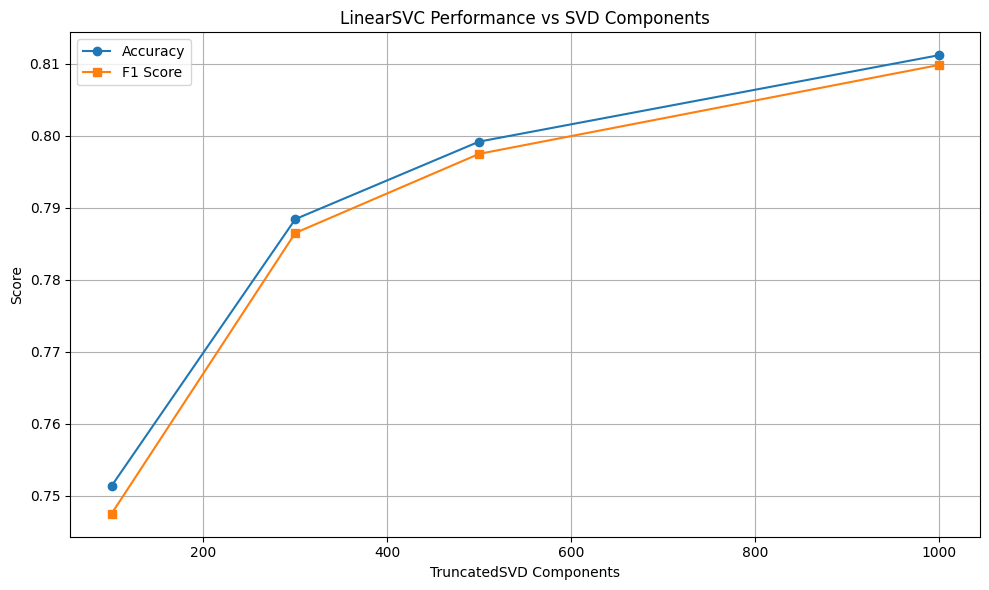

In [5]:
# 4. Save results and plot
results_df = pd.DataFrame(results)
results_df.to_csv(report_path / "dim_reduction_results.csv", index=False)

plt.figure(figsize=(10, 6))
plt.plot(results_df["components"], results_df["accuracy"], marker="o", label="Accuracy")
plt.plot(results_df["components"], results_df["f1_score"], marker="s", label="F1 Score")
plt.xlabel("TruncatedSVD Components")
plt.ylabel("Score")
plt.title("LinearSVC Performance vs SVD Components")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(report_path / "svd_component_plot.png")
plt.show()

In [6]:
# 5. Inspect top terms for first few components
print("\nTop terms per SVD component (based on absolute weight):")
svd_inspect = TruncatedSVD(n_components=10, random_state=42)
svd_inspect.fit(X_train)
feature_names = vectorizer.get_feature_names_out()

for i, comp in enumerate(svd_inspect.components_):
    terms = zip(feature_names, comp)
    sorted_terms = sorted(terms, key=lambda x: abs(x[1]), reverse=True)[:10]
    print(f"\nComponent {i}:")
    for term, weight in sorted_terms:
        print(f"  {term:20} {weight:.4f}")



Top terms per SVD component (based on absolute weight):

Component 0:
  city                 0.2208
  known                0.1708
  country              0.1434
  film                 0.1410
  world                0.1404
  series               0.1387
  won                  0.1362
  american             0.1321
  title                0.1283
  uk                   0.1278

Component 1:
  city                 0.5510
  capital              0.3121
  country              0.2023
  largest              0.1894
  capital city         0.1526
  film                 -0.1354
  uk                   -0.1337
  song                 -0.1300
  state                0.1221
  number               -0.1185

Component 2:
  uk                   0.3517
  number               0.3154
  song                 0.2708
  hit                  0.2495
  band                 0.1969
  single               0.1843
  won                  -0.1773
  film                 -0.1695
  uk number            0.1593
  series               -0